In [6]:

import sys
import os

# Get the current working directory
current_working_directory = os.getcwd()

# Go up one level from the current working directory
parent_directory = os.path.join(current_working_directory, '..')

# Add the parent directory to sys.path
sys.path.append(parent_directory)

os.getcwd()

'/home/sverre/Downloads/hackathon-2024/task5/notebooks'

## Load data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
from src.data.data_loader import LocalDataLoader 
x, y = LocalDataLoader.load_raw_data()
training_data = pd.concat([x, y], axis=1)

# Display basic information
print(training_data.info())
training_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   TransactionID              400000 non-null  object 
 1   CustomerID                 400000 non-null  int64  
 2   Origin_Currency            400000 non-null  object 
 3   Currency                   400000 non-null  object 
 4   CDB_Location_Country_x     400000 non-null  object 
 5   CDB_Location_CountryCode   400000 non-null  object 
 6   Transaction_Type           400000 non-null  object 
 7   Origin_Date                400000 non-null  object 
 8   System_Date                400000 non-null  object 
 9   Completed_Date             400000 non-null  object 
 10  Origin_Amount              400000 non-null  float64
 11  Amount                     400000 non-null  float64
 12  Merchant_Code              400000 non-null  object 
 13  Deposit_Withdrawal         40

,TransactionID,CustomerID,Origin_Currency,Currency,CDB_Location_Country_x,CDB_Location_CountryCode,Transaction_Type,Origin_Date,System_Date,Completed_Date,...,Transaction_Description_0,Transaction_Description_1,Transaction_Description_2,Transaction_Location,Opposite_party_ID,Opposite_party_Name,Opposite_party_Adress,Opposite_party_City,Opposite_party_Country,IsFraud
0,ICLS-51152875,43696,NOK,NOK,Norway,NO,Card,2024-03-07,2024-03-07,2024-03-09,...,FAY-5809,Ecstasy Amphetamine Speed Testosteron Equasym ...,NaN,Online,NaN,Unknown,NaN,NaN,NaN,0
1,TXMG-13912069,29901,NOK,NOK,Norway,NO,Card,2024-02-20,2024-02-20,2024-02-22,...,XRT-9041,Tonight later and officer behind.,NaN,Online,NaN,Unknown,NaN,NaN,NaN,0
2,QBOU-28520273,16555,NOK,NOK,Norway,NO,Card,2024-02-16,2024-02-16,2024-02-17,...,MMK-3145,First six result out that power can.,NaN,5173,61101.0,Charles James,"0819 Kristin Meadows\nNorth Melissaton, MH 45509",Mollymouth,NIGERIA,0
3,SIJD-97589200,43314,NOK,NOK,Norway,NO,Cash,2024-03-09,2024-03-09,2024-03-11,...,UGU-0850,Cell chance hair treatment group film deal cle...,Better daughter member him home perhaps.,0851,NaN,Unknown,NaN,NaN,NaN,0
4,LWLQ-76991312,25333,NOK,NOK,Norway,NO,Vipps,2024-03-03,2024-03-03,2024-03-05,...,EJC-2516,Item office she she standard wear agency.,Address role speak cost truth book citizen.,0594,41957.0,Abigail Casey,"1025 Tyler Squares\nWest Michaeltown, AK 79151",East Kevinmouth,COLOMBIA,0


## Nan analysis
What fields contains NaN values? How large part are they? How to handle them?

In [33]:
# Find amount of nans in each column
# amount / total 
nans = pd.DataFrame()
nans["amount_nans"] = training_data.isnull().sum()
nans["%"] = (nans["amount_nans"] / training_data.shape[0]) 
nans = nans[nans["amount_nans"] > 0] 
print(nans)

                           amount_nans         %
Transaction_Text                120085  0.300212
Transaction_Description_2       199790  0.499475
Opposite_party_ID               191713  0.479283
Opposite_party_Adress           191713  0.479283
Opposite_party_City             191713  0.479283
Opposite_party_Country          191713  0.479283


### Strategies to deal with NaN values

## Duplicates Analysis
Are there any duplicates in the dataset and in that case how many are there of them? 

In [32]:
duplicate_count = training_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


## Outlier detection

Detected 6269 potential outlier transactions based on amount and count.


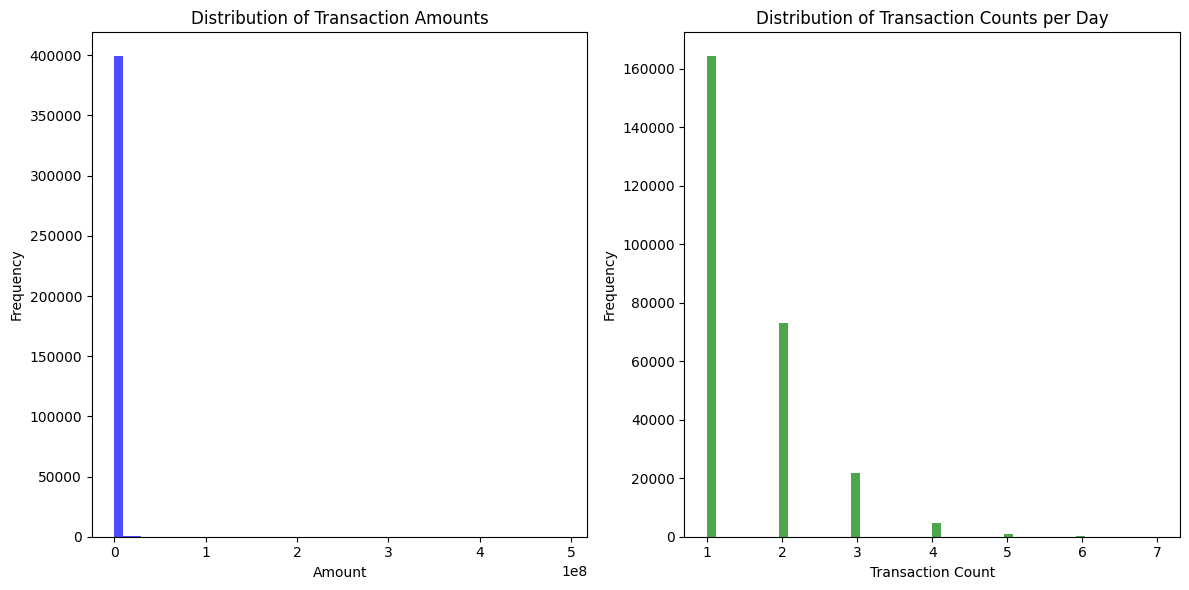

In [ ]:

# Convert date columns to datetime
training_data['Origin_Date'] = pd.to_datetime(training_data['Origin_Date'])
training_data['System_Date'] = pd.to_datetime(training_data['System_Date'])
training_data['Completed_Date'] = pd.to_datetime(training_data['Completed_Date'])

# Analyze transactions by CustomerID and Date
# For simplicity, let's focus on 'Origin_Date' and 'Origin_Amount'
transactions_by_customer_date = training_data.groupby(['CustomerID', 'Origin_Date']).agg({
    'Origin_Amount': ['sum', 'count']
}).reset_index()

# Flatten the multi-level columns
transactions_by_customer_date.columns = ['CustomerID', 'Date', 'Total_Amount', 'Transaction_Count']

# Detect outliers in daily transaction amount and count - basic Z-score thresholding for demonstration
# Feel free to adjust thresholds based on your analysis
mean_amount = transactions_by_customer_date['Total_Amount'].mean()
std_amount = transactions_by_customer_date['Total_Amount'].std()
mean_count = transactions_by_customer_date['Transaction_Count'].mean()
std_count = transactions_by_customer_date['Transaction_Count'].std()

threshold = 3  # Example threshold for Z-score, indicating 3 standard deviations from the mean

# Identifying outliers
transactions_by_customer_date['Amount_Outlier'] = abs(transactions_by_customer_date['Total_Amount'] - mean_amount) > threshold * std_amount
transactions_by_customer_date['Count_Outlier'] = abs(transactions_by_customer_date['Transaction_Count'] - mean_count) > threshold * std_count

# Filter transactions identified as outliers
outlier_transactions = transactions_by_customer_date[(transactions_by_customer_date['Amount_Outlier']) | (transactions_by_customer_date['Count_Outlier'])]

print(f"Detected {len(outlier_transactions)} potential outlier transactions based on amount and count.")

# Optional: Visualize the distribution of transaction amounts and counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(training_data['Origin_Amount'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(transactions_by_customer_date['Transaction_Count'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Transaction Counts per Day')
plt.xlabel('Transaction Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# # Example: Flagging transactions involving high-risk countries
# high_risk_countries = ['Country1', 'Country2', 'Country3']  # Update with actual countries
# outlier_transactions['HighRiskCountry'] = outlier_transactions['Transaction_Location'].isin(high_risk_countries)

# # Example: Flagging large transactions
# threshold_amount = 10000  # Example threshold
# outlier_transactions['LargeTransaction'] = outlier_transactions['Total_Amount'] > threshold_amount

# # Display flagged transactions
# flagged_transactions = outlier_transactions[(outlier_transactions['HighRiskCountry']) | (outlier_transactions['LargeTransaction'])]
# print(flagged_transactions)


KeyError: 'Transaction_Location'